In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)

In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train = load_cls(path+"X_train_tokens.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_tokens.p")

In [5]:
print(len(X_train))

75000


In [6]:
y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

def my_preprocessor(doc):
    return doc

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    return doc

custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm

In [9]:
feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

In [10]:
X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f =feature_pipeline.transform(X_val_cls)

In [82]:
'''
from sklearn.model_selection import GridSearchCV
parameters = {
     'C': [0.001, 0.01, 0.1, 1,10],
     'gamma': [0.001, 0.01, 0.1, 1]
 }
'''
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# cv=3 [1,3,5,7,9,11], [25,39,99,149], [199, 249, 349, 449, 549, 649, 999] done
# cv= 5 [1,3,5,7,9,11], [11, 149, 649, 1299] , [1299, 1599, 1999, 2399] done
parameters = {
     'n_neighbors':[1,3,5,7,9,11]
 }

In [83]:
#gs_clf = GridSearchCV(svm.SVC(verbose=True,probability=True,cache_size=7000,max_iter=n_iter,gamma='auto',kernel='linear'), 
#                      parameters, cv=5, iid=True, n_jobs=-1, verbose=4)

knn = KNeighborsClassifier()

gs_clf = GridSearchCV(knn, parameters, cv = 5, n_jobs=-1, verbose=20)  # scoring = 'accuracy'

In [84]:
model = gs_clf.fit(X_train_f, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  3.0min remaining: 27.0min
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  3.1min remaining: 15.4min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  3.1min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  3.2min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  3.3min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  3.3min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  3.4min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed:  3.4min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  3.5min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  5.8min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapse

In [85]:
print (model.cv_results_)

print (model.best_score_)
print (model.best_params_)
print (model.best_estimator_)

{'mean_fit_time': array([0.06924853, 0.06816459, 0.06591125, 0.06491127, 0.06932025,
       0.07154546]), 'std_fit_time': array([0.00266715, 0.00335584, 0.00125224, 0.00126522, 0.00417524,
       0.00632631]), 'mean_score_time': array([36.57488112, 38.07897406, 41.80879498, 41.32656112, 37.31197934,
       37.14704642]), 'std_score_time': array([1.37064061, 1.27924699, 1.17841473, 0.68314205, 0.5714651 ,
       0.69325667]), 'param_n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 1}, {'n_neighbors': 3}, {'n_neighbors': 5}, {'n_neighbors': 7}, {'n_neighbors': 9}, {'n_neighbors': 11}], 'split0_test_score': array([0.553     , 0.5674    , 0.57473333, 0.5754    , 0.574     ,
       0.58126667]), 'split1_test_score': array([0.54333333, 0.56193333, 0.56353333, 0.55873333, 0.5598    ,
       0.55853333]), 'split2_test_score': array([0.52133333, 0.553866

In [16]:
pickle.dump(model,open("knn_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [108]:
# plot k vs mean_test_score from  GridSearchCV
def GridSearchCV_result():
    k_vector= [1,3,5,7,9, 11, 25,39,99,149,649, 1299,1599, 1999, 2399];
    accuracy_vector= [  0.53366667, 0.55422667, 0.56184   , 0.56152   , 0.56281333,
       0.56462667, # 1,3,5,7,9,11
                       0.57049333, 0.57313333, 0.58334667, 0.58548, # 25,39,99, 149
                        0.59865333, 0.60252, 0.60024, # 649, 1299,1599
                        0.60077333, 0.60262667]; # 1999, 2399
        
        
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(k_vector,accuracy_vector,label='Accuracy vs k',marker='o')
    
    plt.title("Accuracy vs K")
    plt.legend()
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    fig.savefig("knn_k_vs_Acc_plot.png")
    print("Best accuracy= %.4f"%max(accuracy_vector))
    #print(accuracy_vector.index(max(accuracy_vector)))
    print("For k= %d"%k_vector[accuracy_vector.index(max(accuracy_vector))])



Best accuracy= 0.6026
For k= 2399


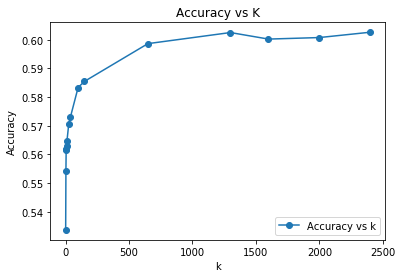

In [109]:
GridSearchCV_result()


In [17]:
X_test = load_cls(path+"X_test_tokens.p")
y_test = load_cls(path+"y_test.p")

In [18]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [19]:
from sklearn.metrics import accuracy_score

In [32]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    '''
    bestModel = svm.SVC(verbose=True,
                        probability=True,
                        cache_size=7000,
                        max_iter=n_iter,
                        gamma=model.best_params_['gamma'],
                        kernel='linear',
                        C=model.best_params_['C'])
    '''
    bestModel = KNeighborsClassifier(n_neighbors= model.best_params_['n_neighbors'],  algorithm='auto',n_jobs=-1)

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = feature_pipeline.transform(X_test)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    print("------------------------------------")
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    

SampleSize: 100
Train Time:0.76 sec
Validation Accuracy: 51.38%
Validation Time:4.40 sec
Test Accuracy: 51.53%
Test Time:2.31 sec
(0.40136709956709904, 0.12666666666666668, 0.4826666666666667)
MRR: 0.40136709956709904
MRR Time:0.61 sec
------------------------------------
SampleSize: 500
Train Time:0.13 sec
Validation Accuracy: 50.33%
Validation Time:2.51 sec
Test Accuracy: 50.49%
Test Time:2.46 sec
(0.3905025012024993, 0.09533333333333334, 0.474)
MRR: 0.3905025012024993
MRR Time:0.92 sec
------------------------------------
SampleSize: 1000
Train Time:0.26 sec
Validation Accuracy: 50.25%
Validation Time:2.70 sec
Test Accuracy: 50.43%
Test Time:2.78 sec
(0.3888444925444908, 0.1, 0.418)
MRR: 0.3888444925444908
MRR Time:1.20 sec
------------------------------------
SampleSize: 10000
Train Time:2.72 sec
Validation Accuracy: 54.09%
Validation Time:6.85 sec
Test Accuracy: 54.51%
Test Time:6.88 sec
(0.4374924482924472, 0.16266666666666665, 0.514)
MRR: 0.4374924482924472
MRR Time:5.06 sec
---

In [31]:

print ("Val accuracy:")
print (valAccuracy)
print ("Test accuracy:")
print (testAccuracy)
print ("MRR score:")
print (mrrScore)
print ("precision At1:")
print (precisionAt1)
print ("precision At3:")
print (precisionAt3)

Val accuracy:
[0.5138, 0.5033, 0.5025, 0.5409, 0.5401, 0.5488, 0.5535]
Test accuracy:
[0.5153, 0.5049, 0.5043, 0.5451, 0.5381, 0.5373, 0.5427]
MRR score:
[0.40136709956709904, 0.3905025012024993, 0.3888444925444908, 0.4374924482924472, 0.42186507936507844, 0.4319627224627211, 0.43009860509860454]
precision At1:
[0.12666666666666668, 0.09533333333333334, 0.1, 0.16266666666666665, 0.14133333333333334, 0.15733333333333333, 0.14933333333333335]
precision At3:
[0.4826666666666667, 0.474, 0.418, 0.514, 0.49866666666666665, 0.5186666666666667, 0.5273333333333333]


In [33]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Accuracy vs TrainData size")
    plt.legend()
    plt.xlabel("TrainData size")
    plt.ylabel("Accuracy")
    fig.savefig("knn_Tokens_Accuracy.png")
    #plt.show()

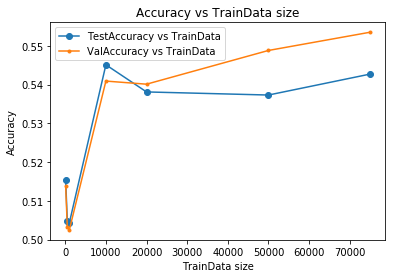

In [34]:
accuracyVisualization()

In [35]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("MRR vs TrainData size")
    plt.legend()
    plt.xlabel("TrainData size")
    plt.ylabel("MRR")
    fig.savefig("knn_Tokens_Mrr.png")
    plt.show()

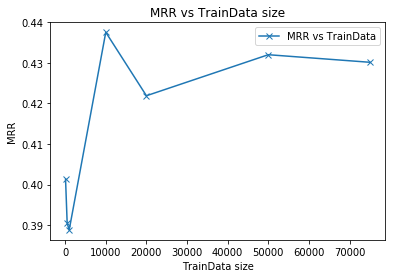

In [36]:
mrrVisualization()

In [37]:
def precisionVisualization():
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='o')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='x')
    plt.title("Precision vs TrainData size")
    plt.legend()
    plt.xlabel("TrainData size")
    plt.ylabel("Precision")
    fig.savefig("knn_Tokens_Precision.png")
    #plt.show()

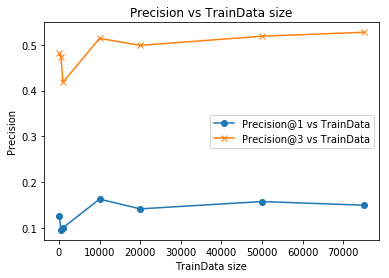

In [38]:
precisionVisualization()